In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

2.3.0


In [2]:
from collections import defaultdict

In [3]:
# Loading fashion mnist data 
dataset, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

Training set contains 60k data points and test set contains 10k data points. 

In [5]:
type(dataset)

dict

In [6]:
dataset.keys()

dict_keys(['test', 'train'])

In [7]:
# Get test and train dataset.
train_dataset, test_dataset = dataset['train'], dataset['test']

In [8]:
type(train_dataset)  # type DatasetV1Adapter was supported in TF 1.x

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

2


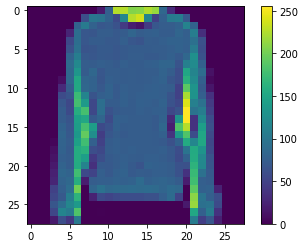

1


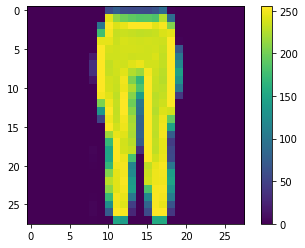

In [9]:
for image, label in train_dataset.take(2):
  print(label.numpy())
  image = image.numpy().reshape((28, 28))
  
  plt.figure()
  plt.imshow(image) # Adding cmap=plt.cm.binary sets the colormap to binary 
  plt.colorbar()
  plt.show()

In [10]:
print(info.features['label'].num_classes)
print(info.features['label'].names)
print(info.features["label"].int2str(7))

10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Sneaker


## Normalize the data

In [11]:
def get_normalized_images(images, labels):
  images = tf.cast(images, tf.float32)
  images = images/255
  return images, labels

In [12]:
norm_train_dataset = train_dataset.map(get_normalized_images)
norm_test_dataset = test_dataset.map(get_normalized_images)

2


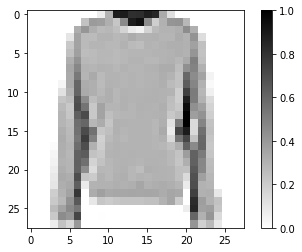

1


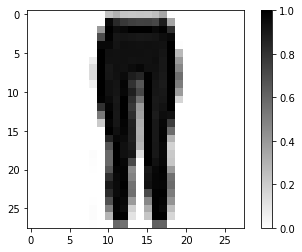

In [13]:
for image, label in norm_train_dataset.take(2):
  print(label.numpy())
  image = image.numpy().reshape((28, 28))

  plt.figure()
  plt.imshow(image, cmap=plt.cm.binary) 
  plt.colorbar()
  plt.show()

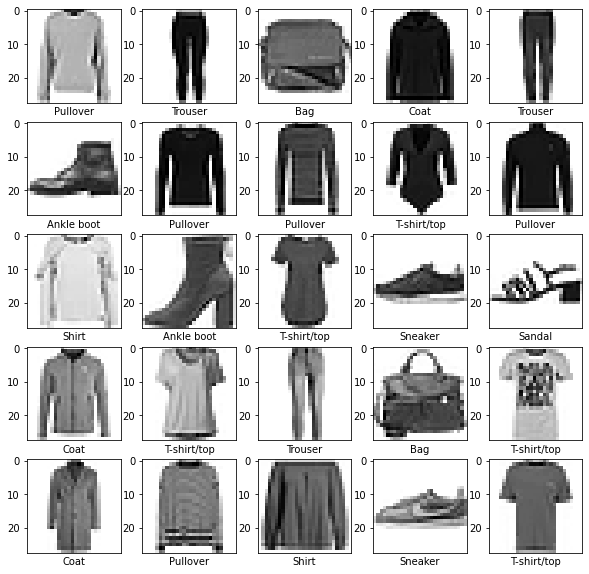

In [14]:
plt.figure(figsize=(10,10))
i = 0
for image, label in norm_train_dataset.take(25):
  image = image.numpy().reshape((28,28))

  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(info.features["label"].int2str(label))
  i += 1

plt.show()

## Model Building

In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [17]:
BATCH_SIZE = 32
norm_train_dataset = norm_train_dataset.cache().repeat().shuffle(info.splits['train'].num_examples) \
                .batch(BATCH_SIZE)
norm_test_dataset = norm_test_dataset.cache().batch(BATCH_SIZE)

In [18]:
model.fit(norm_train_dataset, epochs=5, \
          steps_per_epoch=math.ceil(info.splits['train'].num_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4962 - accuracy: 0.8252
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3792 - accuracy: 0.8618
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3366 - accuracy: 0.8785
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3093 - accuracy: 0.8866
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3016 - accuracy: 0.8897


In [19]:
test_loss, test_accuracy = model.evaluate(norm_test_dataset, steps=math.ceil(info.splits['test'].num_examples/32))


313/313 [==============================] - 2s 6ms/step - loss: 0.3434 - accuracy: 0.8764


In [20]:
test_accuracy

0.8763999938964844

In [36]:
for test_images, test_labels in norm_test_dataset.take(100):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)